# Classifying and analyzing temporal travel patterns (Tourist vs. Resident)


## 1. Setup and Imports

### Imports

In [1]:
# Spark SQL Imports
from pyspark.sql.types import *
from pyspark.sql import functions as F

# ML Algorithms
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Common Data Science Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

StatementMeta(dslsmall, 463, 2, Finished, Available)

In [8]:
#import sys
#import pyspark
#import matplotlib
#import sklearn
#
## Print out the version information
#print("Python version:", sys.version)
#print("PySpark version:", pyspark.__version__)
#print("Pandas version:", pd.__version__)
#print("NumPy version:", np.__version__)
#print("Matplotlib version:", matplotlib.__version__)
#print("Scikit-learn version:", sklearn.__version__)

StatementMeta(dslsmall, 463, 9, Finished, Available)

Python version: 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:35:26) [GCC 10.4.0]
PySpark version: 3.3.1
Pandas version: 1.5.1
NumPy version: 1.23.4
Matplotlib version: 3.6.2
Scikit-learn version: 1.1.3


### Constants

In [3]:
# May Months (Normal)
start_date = "2023-03-08 00:00:00"
end_date = "2023-07-14 00:00:00"
MAY_MONTHS = [start_date, end_date]

# July Months (Abnormal)
start_date = "2023-05-10 00:00:00"
end_date = "2023-09-16 00:00:00"
JULY_MONTHS = [start_date, end_date]

# May Week (Normal)
start_date = "2023-05-08 00:00:00"
end_date = "2023-05-14 00:00:00"
MAY_WEEK = [start_date, end_date]

# July Week (Abnormal)
start_date = "2023-07-10 00:00:00"
end_date = "2023-07-16 00:00:00"
JULY_WEEK = [start_date, end_date]

# Day and hour mappings
DAY_MAPPING = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday' }

HOUR_MAPPING = {
    0: 'Night', 1: 'Night', 2: 'Night', 3: 'Night', 4: 'Night',
    5: 'Morning', 6: 'Morning', 7: 'Morning', 8: 'Morning', 9: 'Morning',
    10: 'Day', 11: 'Day', 12: 'Day', 13: 'Day', 14: 'Day', 15: 'Day',
    16: 'Afternoon', 17: 'Afternoon', 18: 'Afternoon',
    19: 'Evening', 20: 'Evening', 21: 'Evening', 22: 'Evening', 23: 'Evening'
}

# Sorting weekly profiles
HOUR_ORDER = ['Night', 'Morning', 'Day', 'Afternoon', 'Evening']
DAYS_ORDER = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

StatementMeta(dslsmall, 462, 4, Finished, Available)

In [4]:
TICKET_CATEGORIES = ["Adult", "Tourist", "Single"]
CATEGORY_MAPPING = {
    "30-dagarsbiljetter": "Adult", "90-dagarsbiljetter": "Adult", "Års-och företagsbiljetter": "Adult",
    "7-dagarsbiljett": "Tourist", "72-timmarsbiljett inkl app": "Tourist", "24-timmarsbiljett inkl app": "Tourist",  # 24timmarsbiljett inkl app
    "Reskassa": "Single", "Kontaktlöst": "Single", "Mobilbiljett": "Single", "Zon och Automatbiljetter": "Single" # Previously Single
}

TICKET_MAPPING = {
    'Skolbiljett vårtermin': 'Skol- termins och fritidsbiljett', 'Skolbiljett hösttermin': 'Skol- termins och fritidsbiljett', 'Skolbiljett vårtermin skola': 'Skol- termins och fritidsbiljett', 
    'Skolbiljett hösttermin skola': 'Skol- termins och fritidsbiljett', 'Skolbiljett 90 dagar': 'Skol- termins och fritidsbiljett', 'Skolbiljett 90 dagar skola': 'Skol- termins och fritidsbiljett', 
    'Skolbiljett 120 dagar': 'Skol- termins och fritidsbiljett', 'Skolbiljett 120 dagar skola': 'Skol- termins och fritidsbiljett', 'Fritidsbiljett Hösttermin': 'Skol- termins och fritidsbiljett', 
    'Fritidsbiljett 90 dagar': 'Skol- termins och fritidsbiljett', 'Fritidsbiljett vårtermin': 'Skol- termins och fritidsbiljett', 'Fritidsbiljett 120 dagar': 'Skol- termins och fritidsbiljett', 
    'Läsårsbiljett plus skola': 'Skol- termins och fritidsbiljett', 'Läsårsbiljett skola': 'Skol- termins och fritidsbiljett', 'Fritidsbiljett 90 dagar skola': 'Skol- termins och fritidsbiljett', 
    'Skolbiljett UL/SL vårtermin': 'Skol- termins och fritidsbiljett', 'Fritidsbiljett UL/SL vårtermin': 'Skol- termins och fritidsbiljett', 
    'Skolbiljett UL/SL vårtermin Skola': 'Skol- termins och fritidsbiljett', 'Skolbiljett UL/SL hösttermin': 'Skol- termins och fritidsbiljett', 
    'Skolbiljett UL/SL hösttermin Skola': 'Skol- termins och fritidsbiljett', 'Fritidsbiljett UL/SL hösttermin': 'Skol- termins och fritidsbiljett', 
    'Fritidsbiljett 120 dagar skola': 'Skol- termins och fritidsbiljett', 'Fritidsbiljett HT Skola': 'Skol- termins och fritidsbiljett', 
    'Fritidsbiljett VT Skola': 'Skol- termins och fritidsbiljett', 'USLUL125': 'Zon och Automatbiljetter', 'USLUL25': 'Zon och Automatbiljetter', 'Årsbiljett Resplus': 'Års-och företagsbiljetter', 
    'Reskassa': 'Reskassa', '7-dagar vuxen': '7-dagarsbiljett', '7-dagar vuxen ftg': '7-dagarsbiljett', '24-timmar vuxen': '24-timmarsbiljett inkl app', '72-timmar vuxen': '72-timmarsbiljett inkl app', 
    'Arlanda + SL vuxen endast 1 passage': 'Zon och Automatbiljetter', 'Enkelbiljett_vuxen': 'Zon och Automatbiljetter', 'Enkelbiljett vuxen': 'Kontaktlöst', '30-dagar rabatterad': '30-dagarsbiljetter', 
    '30-dagar rabatterad ftg': '30-dagarsbiljetter', '30-dagar Arlanda rabatterad': '30-dagarsbiljetter', '90-dagar rabatterad': '90-dagarsbiljetter', '90-dagar rabatterad ftg': '90-dagarsbiljetter', 
    'Årsbiljett Jan-Dec rabatterad': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad ftg': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad': 'Års-och företagsbiljetter', 
    '7-dagar rabatterad': '7-dagarsbiljett', '7-dagar rabatterad ftg': '7-dagarsbiljett', '24-timmar rabatterad': '24-timmarsbiljett inkl app', '72-timmar rabatterad': '72-timmarsbiljett inkl app', 
    'Arlanda + SL rabatterad endast 1 passage': 'Zon och Automatbiljetter', 'WAX 30 dagar rabatterad': '30-dagarsbiljetter', 'Årsbiljett Jan-Dec FTG- rabatterad': 'Års-och företagsbiljetter', 
    'WAX 30-dagarsbiljett rabatterad FTG': '30-dagarsbiljetter', 'Årsbiljett Ftg rabatterad': 'Års-och företagsbiljetter', 'Enkelbiljett_rabatterad': 'Zon och Automatbiljetter', 
    'Enkelbiljett rabatterad': 'Kontaktlöst', 'Årsbiljett rabatterad sep - aug FTG': 'Års-och företagsbiljetter', 'RAB': 'Mobilbiljett', 'RABP': 'Zon och Automatbiljetter', 
    'Årsbiljett rabatterad jan - dec FTG': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad feb - jan FTG': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad mar - feb FTG': 'Års-och företagsbiljetter', 
    'Årsbiljett rabatterad apr - mar FTG': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad maj - apr FTG': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad jun - maj FTG': 'Års-och företagsbiljetter', 
    'Årsbiljett rabatterad jul - jun FTG': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad aug - jul FTG': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad okt - sep FTG': 'Års-och företagsbiljetter', 
    'Årsbiljett rabatterad nov - okt FTG': 'Års-och företagsbiljetter', 'Årsbiljett rabatterad dec - nov FTG': 'Års-och företagsbiljetter', 'MORAB30': '30-dagarsbiljetter', 'MORAB30P': '30-dagarsbiljetter', 
    'MORAB90': '90-dagarsbiljetter', 'MORAB365': 'Års-och företagsbiljetter', '30-dagar vuxen': '30-dagarsbiljetter', '30-dagar vuxen ftg': '30-dagarsbiljetter', 
    '30-dagar Arlanda vuxen': '30-dagarsbiljetter', '30-dagar UL/SL vuxen': '30-dagarsbiljetter', '90-dagar vuxen': '90-dagarsbiljetter', '90-dagar vuxen ftg': '90-dagarsbiljetter', 
    'Årsbiljett Jan-Dec vuxen': 'Års-och företagsbiljetter', 'Årsbiljett vuxen ftg': 'Års-och företagsbiljetter', 'Årsbiljett vuxen': 'Års-och företagsbiljetter', 'WAX 30 dagar vuxen': '30-dagarsbiljetter', 
    'Årsbiljett Jan-Dec FTG- vuxen': 'Års-och företagsbiljetter', 'WAX 30-dagarsbiljett vuxen FTG': '30-dagarsbiljetter', 'Årsbiljett Ftg vuxen': 'Års-och företagsbiljetter', 
    'Årsbiljett vuxen sep - aug FTG': 'Års-och företagsbiljetter', 'VUX': 'Mobilbiljett', 'VSLUL125': 'Zon och Automatbiljetter', 'VSLUL25': 'Zon och Automatbiljetter', 'VUXP': 'Zon och Automatbiljetter', 
    'Årsbiljett vuxen jan - dec FTG': 'Års-och företagsbiljetter', 'Årsbiljett vuxen feb - jan FTG': 'Års-och företagsbiljetter', 'Årsbiljett vuxen mar - feb FTG': 'Års-och företagsbiljetter', 
    'Årsbiljett vuxen apr - mar FTG': 'Års-och företagsbiljetter', 'Årsbiljett vuxen maj - apr FTG': 'Års-och företagsbiljetter', 'Årsbiljett vuxen jun - maj FTG': 'Års-och företagsbiljetter', 
    'Årsbiljett vuxen jul - jun FTG': 'Års-och företagsbiljetter', 'Årsbiljett vuxen aug - jul FTG': 'Års-och företagsbiljetter', 'Årsbiljett vuxen okt - sep FTG': 'Års-och företagsbiljetter', 
    'Årsbiljett vuxen nov - okt FTG': 'Års-och företagsbiljetter', 'Årsbiljett vuxen dec - nov FTG': 'Års-och företagsbiljetter', 'MOVUX30': '30-dagarsbiljetter', 'MOVUX30P': '30-dagarsbiljetter', 
    'MOVUX90': '90-dagarsbiljetter', 'MOVUX90P': '90-dagarsbiljetter', 'MOVUX365': 'Års-och företagsbiljetter', 
    'VUX30D': '30-dagarsbiljetter', 'VUX90D': '90-dagarsbiljetter', 'VUX30DP': '30-dagarsbiljetter',
    'VUX120MIN': '', 'VUX120MIN': '',
    'VUX24H': '24-timmarsbiljett inkl app', 'VUX72H': '72-timmarsbiljett inkl app', 'VUX7D': '7-dagarsbiljett', 
    'RAB72H': '72-timmarsbiljett inkl app', 'RAB24HUL': '24-timmarsbiljett inkl app', 'RAB24H': '24-timmarsbiljett inkl app', '24-timmar vuxen ftg': '24-timmarsbiljett inkl app', 'RAB7D': '7-dagarsbiljett'
}

StatementMeta(dslsmall, 462, 5, Finished, Available)

## Show ticket types available

In [5]:
def find_ticket_category(product_name):
    # Convert the product name to lowercase to ensure case-insensitive matching
    product_name = product_name.lower()
    
    # Iterate over each key in the mapping
    for key, category in TICKET_MAPPING.items():
        # If the key is a substring of the product name, return the category
        if key.lower() in product_name:
            return category
    # If no keys match, return 'Unknown'
    return 'Unknown'

def get_ticket_types():
    product_query = """
            SELECT 
                ProductName, SalesProductGroupName AS TicketType
            FROM  `analysis_dm`.`DimValidationProduct` 
            WHERE 1=1
                AND SalesProductGroupName != "Unknown"
    """
    data_df = spark.sql(product_query)
    data_pdf = data_df.toPandas()

    data_pdf['TicketCategory'] = data_pdf['ProductName'].map(TICKET_MAPPING).map(CATEGORY_MAPPING)
    #data_pdf.dropna(subset=['TicketCategory'], inplace=True) # For those items not mapped

    return data_pdf

# Fetch the unique ticket types with their counts
ticket_types_pdf = get_ticket_types()
display(ticket_types_pdf)

StatementMeta(dslsmall, 462, 6, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


SynapseWidget(Synapse.DataFrame, 451ea2dc-709e-417f-90c6-b5bfaa120a8c)

## 2. Data Preprocessing

In [6]:
def get_data(time_period):
    """
    Fetches and prepares weekly profiles for each user over a specified time period.

    Parameters:
    - time_period: Tuple of start_date and end_date in the format "YYYY-MM-DD HH:MM:SS".

    Returns:
    - A Pandas DataFrame with the weekly profiles of journeys per user.
    """
    data_pdf = fetch_data(time_period)
    data_pdf = process_data(data_pdf)

    return data_pdf

def fetch_data(time_period):
    start_date, end_date = time_period
    query = f"""
        SELECT 
            j.CardKey, 
            d.DayOfWeek, 
            FLOOR(j.origin_sfm / 3600) AS InHour, 
            p.ProductName
        FROM `analysis_dm`.`travelpatternjourney` AS j
        LEFT JOIN `analysis_dm`.`dimcalendardate` AS d 
            ON d.calendarDateKey = j.origin_CalendarDateKey
        LEFT JOIN `analysis_dm`.`dimvalidationproduct` AS p 
            ON p.ValidationProductKey = j.ValidationProductKey
        WHERE 1=1
            AND d.FullDate BETWEEN '{start_date}' AND '{end_date}'
    """
    data_df = spark.sql(query).na.drop()
    data_pdf = data_df.toPandas()
    data_pdf['DayOfWeek'] = data_pdf['DayOfWeek'].map(DAY_MAPPING)
    return data_pdf

def process_data(data_pdf):
    # Map hour and day, then encode and group in fewer steps
    data_pdf['Day_Hour'] = data_pdf['DayOfWeek'] + "_" + data_pdf['InHour'].map(HOUR_MAPPING)
    data_pdf = pd.get_dummies(data_pdf, columns=['Day_Hour'], prefix="Time", prefix_sep="_")
    data_pdf.drop(columns=["InHour", "DayOfWeek"], inplace=True)

    # Simplify tickets
    data_pdf['TicketCategory'] = data_pdf['ProductName'].map(TICKET_MAPPING).map(CATEGORY_MAPPING)
    missing_ticket_category = data_pdf[data_pdf['TicketCategory'].isnull()]

    # Print ProductName entries that could not be mapped
    #print("ProductNames not translated into TicketCategory:")
    #print(missing_ticket_category['ProductName'])

    data_pdf.dropna(subset=['TicketCategory'], inplace=True) # For those items not mapped
    data_pdf.drop(columns=["ProductName"], inplace=True)

    # Combine TicketType handling into the grouping operation
    aggregated = data_pdf.groupby('CardKey').agg({
        **{col: 'sum' for col in data_pdf.columns if col.startswith("Time_")},
        'TicketCategory': lambda x: pd.Series.mode(x)[0]  # Mode calculation
    }).reset_index()

    return aggregated

StatementMeta(dslsmall, 462, 7, Finished, Available)

### Fetch the data

In [50]:
# Representation of user based (Weekly Profiles Day_Time-of-Day)
data_pdf = get_data(JULY_WEEK) #TIME_PERIODS[0]
print(f"{data_pdf.columns[:10]}...") # Print first 10 columns

StatementMeta(dslsmall, 462, 51, Finished, Available)

Index(['CardKey', 'Time_Friday_Afternoon', 'Time_Friday_Day',
       'Time_Friday_Evening', 'Time_Friday_Morning', 'Time_Friday_Night',
       'Time_Monday_Afternoon', 'Time_Monday_Day', 'Time_Monday_Evening',
       'Time_Monday_Morning'],
      dtype='object')...


### Visualize Data 

In [54]:
# Show what our data currntly looks like
print(f"We have {len(data_pdf):,} users to cluster")
#print(data_pdf)
print(f"{data_pdf.iloc[0:5, 0:4]}...")
#print(data_pdf.loc[:5, "TicketCategory"])

StatementMeta(dslsmall, 462, 55, Finished, Available)

We have 737,429 users to cluster
   CardKey  Time_Friday_Afternoon  Time_Friday_Day  Time_Friday_Evening
0      127                      0                0                    0
1      174                      0                0                    0
2      293                      0                0                    0
3      327                      0                0                    0
4      335                      0                0                    0...


In [51]:
# How many tickets do we have of each type?
for ticket_category in TICKET_CATEGORIES:
    category_count = len(data_pdf[data_pdf["TicketCategory"] == ticket_category])
    print(f"{ticket_category} has {category_count:,} users ")

StatementMeta(dslsmall, 462, 52, Finished, Available)

Adult has 202,691 users 
Tourist has 37,563 users 
Single has 497,175 users 


### Apply SMOTE and Split

In [55]:
# Separate the data based on the TicketCategory
single_df = data_pdf[data_pdf['TicketCategory'] == 'Single']
adult_df = data_pdf[data_pdf['TicketCategory'] == 'Adult']
tourist_df = data_pdf[data_pdf['TicketCategory'] == 'Tourist']

# Downsample each category
single_downsampled = single_df.sample(frac=0.25, random_state=42)
adult_downsampled = adult_df.sample(frac=0.50, random_state=42)
tourist_downsampled = tourist_df.sample(frac=1.0, random_state=42)

# Combine the downsampled data
downsampled_data = pd.concat([single_downsampled, adult_downsampled, tourist_downsampled])

# Collect tourist keys
tourist_cards = tourist_df["CardKey"]
# print(tourist_cards)

StatementMeta(dslsmall, 462, 56, Finished, Available)

In [56]:
# Split into X and Y first
X = downsampled_data.drop('TicketCategory', axis=1)
y = downsampled_data['TicketCategory']

# Split into 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

StatementMeta(dslsmall, 462, 57, Finished, Available)

In [59]:
print("Training set distribution:")
print(y_train.value_counts())

print("Test set distribution:")
print(y_test.value_counts())

StatementMeta(dslsmall, 462, 60, Finished, Available)

Training set distribution:
Single     87150
Adult      70871
Tourist    26221
Name: TicketCategory, dtype: int64
Test set distribution:
Single     37144
Adult      30475
Tourist    11342
Name: TicketCategory, dtype: int64


### Drop the CardKey

In [60]:
# Extract CardKey for later use
card_keys_test = X_test['CardKey']

# Drop CardKey from features for training and testing
X_train = X_train.drop('CardKey', axis=1)
X_test = X_test.drop('CardKey', axis=1)

StatementMeta(dslsmall, 462, 61, Finished, Available)

## 3. Training Models and Evaluation

### Random Forests

In [61]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100) # Number of trees to use

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Convert y_pred to a pandas Series with the same index as X_test
y_pred = pd.Series(y_pred, index=X_test.index) # Make sure indexing is correct

StatementMeta(dslsmall, 462, 62, Finished, Available)

### Evaluation

In [62]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Accuracy: {f1}")

StatementMeta(dslsmall, 462, 63, Finished, Available)

Accuracy: 0.7684933068223554
Confusion Matrix:
[[22927  6351  1197]
 [ 3891 31966  1287]
 [ 2176  3378  5788]]
Classification Report:
              precision    recall  f1-score   support

       Adult       0.79      0.75      0.77     30475
      Single       0.77      0.86      0.81     37144
     Tourist       0.70      0.51      0.59     11342

    accuracy                           0.77     78961
   macro avg       0.75      0.71      0.72     78961
weighted avg       0.77      0.77      0.76     78961



## 4. Visualize those who were predicted poorly

In [63]:
# Identify incorrect predictions
correct_indices = y_test[y_test == y_pred].index
incorrect_indices = y_test[y_test != y_pred].index

# Extract incorrect instances and their CardKeys
incorrect_instances = X_test.loc[incorrect_indices]
true_labels = y_test.loc[incorrect_indices]
predicted_labels = y_pred.loc[incorrect_indices]
card_keys_incorrect = card_keys_test.loc[incorrect_indices]

# Combine incorrect instances with true labels, predicted labels, and CardKey
incorrect_instances['TrueLabel'] = true_labels
incorrect_instances['PredictedLabel'] = predicted_labels
incorrect_instances['CardKey'] = card_keys_incorrect

# Extract correct instances and their CardKeys
correct_instances = X_test.loc[correct_indices]
true_labels = y_test.loc[correct_indices]
predicted_labels = y_pred.loc[correct_indices]
card_keys_correct = card_keys_test.loc[correct_indices]

# Combine incorrect instances with true labels, predicted labels, and CardKey
correct_instances['TrueLabel'] = true_labels
correct_instances['PredictedLabel'] = predicted_labels
correct_instances['CardKey'] = card_keys_correct

# Print the combined DataFrame
print("Incorrect instances with true and predicted labels and CardKey:")
print(card_keys_incorrect) #incorrect_instances

StatementMeta(dslsmall, 462, 64, Finished, Available)

Incorrect instances with true and predicted labels and CardKey:
633993    69548211
373287    61102712
204799    57033950
422041    62521826
333967    59815544
            ...   
180072    56345965
563623    66732284
721567    70046023
648213    69580592
714310    70014840
Name: CardKey, Length: 18280, dtype: int64


### Query for data

In [64]:
def get_trip_data(time_period):
    start_date, end_date = time_period
    query = f"""
        SELECT 
            t.CardKey, 
            t.tapin_CalendarDateKey,
            t.LineNumber,
            t.WaitingTimeSeconds,
            FLOOR(t.InVehicleTimeSeconds / 60) AS InVehicleTimeMinutes,
            l.DepartureLineTransportMode AS LineTransportMode
        FROM `analysis_dm`.`travelpatterntrips` AS t
        LEFT JOIN `analysis_dm`.`dimcalendardate` AS d 
            ON d.calendarDateKey = t.tapin_CalendarDateKey
        LEFT JOIN `analysis_dm`.`dimdeparture` AS l
            ON l.DepartureKey = t.DepartureKey
        WHERE 1=1
            AND d.FullDate BETWEEN '{start_date}' AND '{end_date}'
    """
    data_df = spark.sql(query).na.drop()
    data_pdf = data_df.toPandas()
    return data_pdf

def get_journey_data(time_period):
    start_date, end_date = time_period
    query = f"""
        SELECT 
            j.CardKey, 
            FLOOR(j.travel_time / 60) AS TravelTimeMinutes,
            FLOOR(j.journey_sum_trip_distance / 1000) AS JourneyDistanceKm,
            FLOOR(j.journey_spherical_distance / 1000) AS JourneySphericalDistanceKm,
            FLOOR(j.origin_sfm / 3600) AS FirstTapInHour,
            j.journey_sum_trip_completed,
            j.n_trips,
            d.DayOfWeek
        FROM `analysis_dm`.`travelpatternjourney` AS j
        LEFT JOIN `analysis_dm`.`dimcalendardate` AS d 
            ON d.calendarDateKey = j.origin_CalendarDateKey
        WHERE 1=1
            AND d.FullDate BETWEEN '{start_date}' AND '{end_date}'
    """
    data_df = spark.sql(query).na.drop()
    data_pdf = data_df.toPandas()
    data_pdf['DayOfWeek'] = data_pdf['DayOfWeek'].map(DAY_MAPPING)
    return data_pdf

StatementMeta(dslsmall, 462, 65, Finished, Available)

In [65]:
# query all data during our period...
full_trip_pdf = get_trip_data(JULY_WEEK)
full_journey_pdf = get_journey_data(JULY_WEEK)

StatementMeta(dslsmall, 462, 66, Finished, Available)

In [66]:
# Ensure that CardKey indices used for mapping are unique
incorrect_instances = incorrect_instances.drop_duplicates(subset=['CardKey'])
correct_instances = correct_instances.drop_duplicates(subset=['CardKey'])

# Merge labels with the original trip and journey data based on CardKey
full_trip_pdf['TrueLabel'] = full_trip_pdf['CardKey'].map(incorrect_instances.set_index('CardKey')['TrueLabel']).fillna(
    full_trip_pdf['CardKey'].map(correct_instances.set_index('CardKey')['TrueLabel']))

full_journey_pdf['TrueLabel'] = full_journey_pdf['CardKey'].map(incorrect_instances.set_index('CardKey')['TrueLabel']).fillna(
    full_journey_pdf['CardKey'].map(correct_instances.set_index('CardKey')['TrueLabel']))

StatementMeta(dslsmall, 462, 67, Finished, Available)

In [73]:
# Filter to include only "Adult" true labels
label = "Adult"

trip_pdf = full_trip_pdf[full_trip_pdf['TrueLabel'] == label]
journey_pdf = full_journey_pdf[full_journey_pdf['TrueLabel'] == label]

StatementMeta(dslsmall, 462, 74, Finished, Available)

In [74]:
# Collect only users who were wrong
incorrect_trip_pdf = trip_pdf[trip_pdf["CardKey"].isin(incorrect_instances['CardKey'])]
incorrect_journey_pdf = journey_pdf[journey_pdf["CardKey"].isin(incorrect_instances['CardKey'])]
trips_incorrect = incorrect_trip_pdf.shape[0]
journeys_incorrect = incorrect_journey_pdf.shape[0]

# Collect only users who were right
correct_trip_pdf = trip_pdf[trip_pdf["CardKey"].isin(correct_instances['CardKey'])]
correct_journey_pdf = journey_pdf[journey_pdf["CardKey"].isin(correct_instances['CardKey'])]
trips_correct = correct_trip_pdf.shape[0]
journeys_correct = correct_journey_pdf.shape[0]

StatementMeta(dslsmall, 462, 75, Finished, Available)

StatementMeta(dslsmall, 462, 76, Finished, Available)

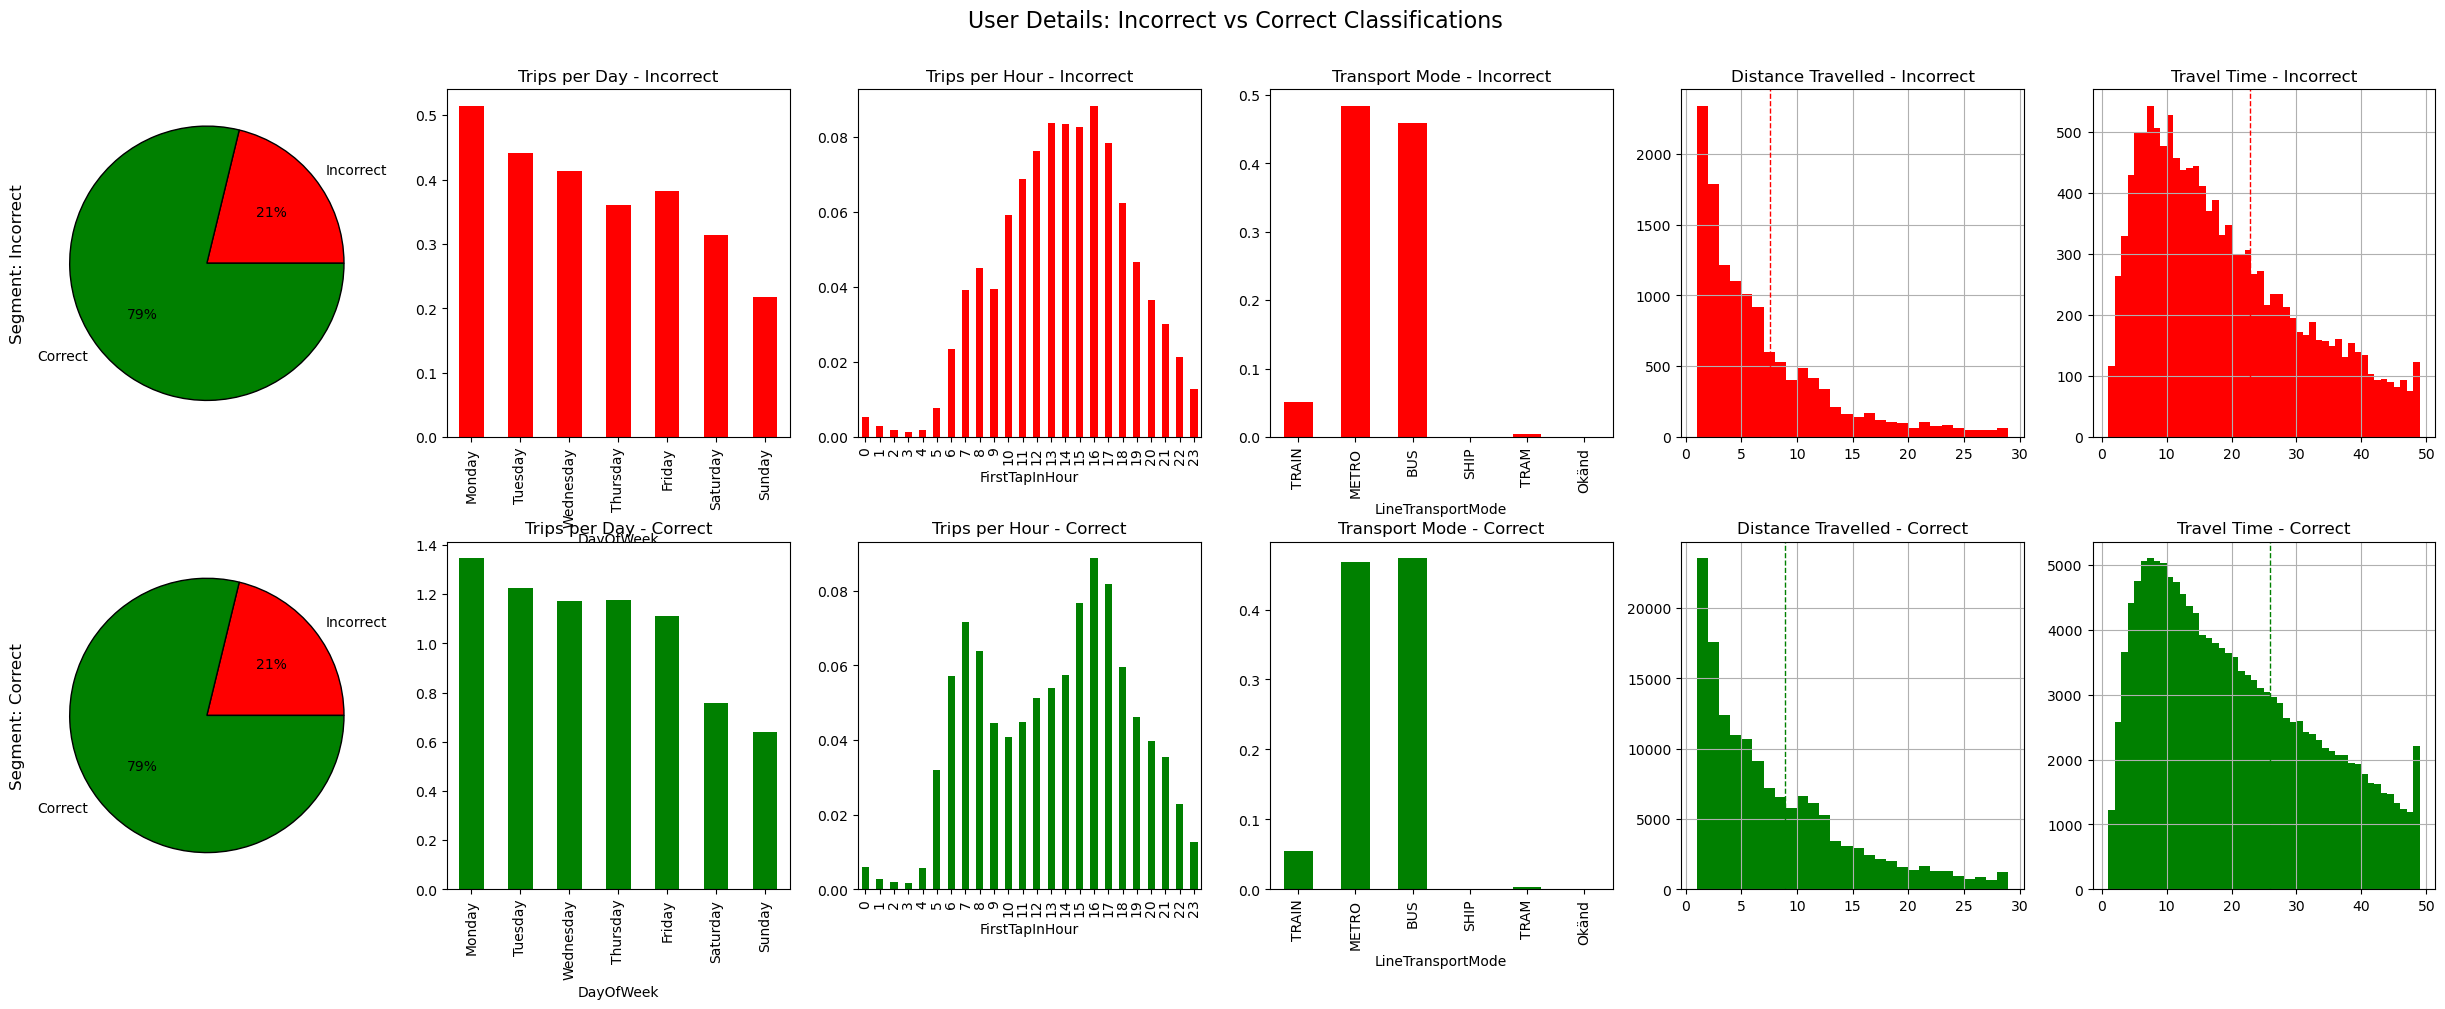

In [75]:
n_days = 7 # Time period dependant, first and last date
total_unique_cards = trip_pdf["CardKey"].nunique()
total_unique_cards_journeys = journey_pdf["CardKey"].nunique()

unique_cards_trips_incorrect = incorrect_trip_pdf["CardKey"].nunique()
unique_cards_journeys_incorrect = incorrect_journey_pdf["CardKey"].nunique()
unique_cards_trips_correct = correct_trip_pdf["CardKey"].nunique()
unique_cards_journeys_correct = correct_journey_pdf["CardKey"].nunique()

trips_per_card_incorrect = "{:.1f}".format(trips_incorrect / unique_cards_trips_incorrect / n_days)
journeys_per_card_incorrect = "{:.1f}".format(journeys_incorrect / unique_cards_journeys_incorrect / n_days)
trips_per_card_correct = "{:.1f}".format(trips_correct / unique_cards_trips_correct / n_days)
journeys_per_card_correct = "{:.1f}".format(journeys_correct / unique_cards_journeys_correct / n_days)

mean_travel_time_minutes_incorrect = incorrect_journey_pdf.loc[(incorrect_journey_pdf['TravelTimeMinutes'] > 0)]['TravelTimeMinutes'].mean()
mean_journey_distance_km_incorrect = incorrect_journey_pdf.loc[(incorrect_journey_pdf['JourneyDistanceKm'] > 0)]['JourneyDistanceKm'].mean()
mean_changes_incorrect = "{:.2f}".format(incorrect_journey_pdf['n_trips'].mean() - 1)

mean_travel_time_minutes_correct = correct_journey_pdf.loc[(correct_journey_pdf['TravelTimeMinutes'] > 0)]['TravelTimeMinutes'].mean()
mean_journey_distance_km_correct = correct_journey_pdf.loc[(correct_journey_pdf['JourneyDistanceKm'] > 0)]['JourneyDistanceKm'].mean()
mean_changes_correct = "{:.2f}".format(correct_journey_pdf['n_trips'].mean() - 1)

trips_correct = correct_trip_pdf["CardKey"].count()
journeys_correct = correct_journey_pdf["CardKey"].count()

# Create subplots with two rows
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(30, 10))
fig.suptitle('User Details: Incorrect vs Correct Classifications', fontsize=16)

# Define function to plot pie chart
def plot_pie(ax, correct, incorrect, title):
    ax.pie([incorrect, correct], labels=['Incorrect', 'Correct'], autopct='%.0f%%', colors=['red', 'green'], wedgeprops={"edgecolor": "black", 'linewidth': 1, 'antialiased': True})
    ax.set_ylabel(title, fontsize=12)

# Number of unique cards
plot_pie(axes[0, 0], unique_cards_trips_correct, unique_cards_trips_incorrect, 'Segment: Incorrect')
plot_pie(axes[1, 0], unique_cards_trips_correct, unique_cards_trips_incorrect, 'Segment: Correct')

# Trips per day
def plot_trips_per_day(ax, df, title, color):
    df.groupby('DayOfWeek').count().transform(lambda x: x / df['CardKey'].nunique()).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(kind='bar', y='CardKey', legend=None, color=color, ax=ax, rot=90)
    ax.set_title(title)

plot_trips_per_day(axes[0, 1], incorrect_journey_pdf, 'Trips per Day - Incorrect', 'red')
plot_trips_per_day(axes[1, 1], correct_journey_pdf, 'Trips per Day - Correct', 'green')

# Trips per hour
def plot_trips_per_hour(ax, df, title, color):
    df.groupby(['FirstTapInHour']).count().transform(lambda x: x / x.sum()).plot(kind='bar', y='CardKey', legend=None, color=color, ax=ax)
    ax.set_title(title)

plot_trips_per_hour(axes[0, 2], incorrect_journey_pdf, 'Trips per Hour - Incorrect', 'red')
plot_trips_per_hour(axes[1, 2], correct_journey_pdf, 'Trips per Hour - Correct', 'green')

# Mode of Transportation
def plot_transport_mode(ax, df, title, color):
    df.groupby(['LineTransportMode']).count().transform(lambda x: x / x.sum()).reindex(['TRAIN', 'METRO', 'BUS', 'SHIP', 'TRAM', 'Okänd']).plot(kind='bar', y='CardKey', legend=None, color=color, ax=ax, rot=90)
    ax.set_title(title)

plot_transport_mode(axes[0, 3], incorrect_trip_pdf, 'Transport Mode - Incorrect', 'red')
plot_transport_mode(axes[1, 3], correct_trip_pdf, 'Transport Mode - Correct', 'green')

# Distance travelled
def plot_distance_travelled(ax, df, title, mean_distance, color):
    df.loc[(df['journey_sum_trip_completed'] == True)].hist(column='JourneyDistanceKm', bins=range(1, 30, 1), range=[1, 30], legend=None, color=color, ax=ax)
    ax.axvline(mean_distance, color=color, linestyle='--', linewidth=1)
    ax.set_title(title)

plot_distance_travelled(axes[0, 4], incorrect_journey_pdf, 'Distance Travelled - Incorrect', mean_journey_distance_km_incorrect, 'red')
plot_distance_travelled(axes[1, 4], correct_journey_pdf, 'Distance Travelled - Correct', mean_journey_distance_km_correct, 'green')

# Travel time
def plot_travel_time(ax, df, title, mean_time, color):
    df.loc[(df['journey_sum_trip_completed'] == True)].hist(column='TravelTimeMinutes', bins=range(1, 50, 1), range=[1, 50], legend=None, color=color, ax=ax)
    ax.axvline(mean_time, color=color, linestyle='--', linewidth=1)
    ax.set_title(title)

plot_travel_time(axes[0, 5], incorrect_journey_pdf, 'Travel Time - Incorrect', mean_travel_time_minutes_incorrect, 'red')
plot_travel_time(axes[1, 5], correct_journey_pdf, 'Travel Time - Correct', mean_travel_time_minutes_correct, 'green')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()


### Travel Behavior of Groups

In [76]:
# Frequency of "Tourist cards being bought?"
def get_product_data(time_period):
    start_date, end_date = time_period
    query = f"""
        SELECT 
            j.CardKey, 
            d.FullDate,
            p.ProductName
        FROM `analysis_dm`.`travelpatternjourney` AS j
        LEFT JOIN `analysis_dm`.`dimcalendardate` AS d 
            ON d.calendarDateKey = j.origin_CalendarDateKey
        LEFT JOIN `analysis_dm`.`dimvalidationproduct` AS p 
            ON p.ValidationProductKey = j.ValidationProductKey
        WHERE 1=1
            AND d.FullDate BETWEEN '{start_date}' AND '{end_date}'
    """
    data_df = spark.sql(query).na.drop()
    return data_df.toPandas()

data_pdf = get_product_data(JULY_MONTHS)

StatementMeta(dslsmall, 462, 77, Finished, Available)

In [77]:
# Filter out only "our" tourists
tourist_pdf = data_pdf[data_pdf["CardKey"].isin(tourist_cards)]
unique_tourists = tourist_pdf["CardKey"].nunique()
print(f"We got {unique_tourists} tourists during these months")

# Remove duplicate rows based on CardKey and FullDate
tourist_pdf = tourist_pdf.drop_duplicates(subset=['CardKey', 'FullDate'])

# Extract users with multiple rows
multiple_rows = tourist_pdf.groupby('CardKey').filter(lambda x: len(x) > 1)

StatementMeta(dslsmall, 462, 78, Finished, Available)

We got 37563 tourists during these months


In [78]:
# Ensure FullDate is in datetime format
tourist_pdf['FullDate'] = pd.to_datetime(tourist_pdf['FullDate'])

# Extract week number
tourist_pdf['Week'] = tourist_pdf['FullDate'].dt.isocalendar().week

# Extract users with records in at least two different weeks
multiple_weeks = tourist_pdf.groupby('CardKey').filter(lambda x: x['Week'].nunique() > 1)

print("\nUsers with multiple rows from at least two different weeks:")
print(multiple_weeks)

multiple_weeks = multiple_weeks.drop_duplicates(subset=['CardKey', 'ProductName'])

unique_tourists_multiweek = multiple_weeks["CardKey"].nunique()
print(f"We got {unique_tourists_multiweek} traveling multiple weeks")
product_count = multiple_weeks["ProductName"].value_counts()
print(product_count)

StatementMeta(dslsmall, 462, 79, Finished, Available)


Users with multiple rows from at least two different weeks:
            CardKey   FullDate ProductName  Week
9          57037854 2023-05-10      VUX30D    19
562        61480878 2023-05-10      VUX30D    19
676        63689591 2023-05-10      VUX30D    19
677        63689615 2023-05-10      VUX24H    19
747        63693476 2023-05-10      VUX30D    19
...             ...        ...         ...   ...
141761017  69984875 2023-07-16       RAB7D    28
141761020  69985123 2023-07-16      VUX72H    28
141761022  69985130 2023-07-16       RAB7D    28
141761025  69985157 2023-07-16       RAB7D    28
141761032  69985288 2023-07-16       RAB7D    28

[452203 rows x 4 columns]
We got 23572 traveling multiple weeks
VUX7D        9934
VUX72H       5533
VUX          5237
RAB7D        4392
VUX24H       4107
VUX30D       3889
RAB          3030
RAB72H       2409
RAB24H       1888
RAB30D       1591
VUX90D        139
RAB90D        103
SKOLVT         69
SKOLHT         58
WTAX3VUX       57
VSLUL125       4

In [ ]:
# Show frequency and behavior
# Collect all users with multiple purchases

In [ ]:
# Show the stations that the users travelled mostly from and to